In [167]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from functools import partial
from mxnet.gluon import HybridBlock
from pathlib import Path
from itertools import islice
from gluonts.mx import Trainer, as_in_context, batchify, copy_parameters, get_hybrid_forward_input_names, GluonEstimator, RepresentableBlockPredictor, DistributionOutput, GaussianOutput, MeanScaler, NOPScaler 
from gluonts.core.component import validated
from gluonts.dataset.common import ListDataset
from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.model.predictor import Predictor
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.transform import AddAgeFeature, AddObservedValuesIndicator, Chain, ExpectedNumInstanceSampler, InstanceSplitter, SelectFields, SetFieldIfNotPresent, Transformation, TestSplitSampler

In [84]:
mx.random.seed(0)
np.random.seed(0)

# quick start tutorial

In [25]:
dataset = get_dataset("m4_hourly", regenerate=True)
display(dataset.train)

saving time-series into C:\Users\negstek\.mxnet\gluon-ts\datasets\m4_hourly\train\data.json
saving time-series into C:\Users\negstek\.mxnet\gluon-ts\datasets\m4_hourly\test\data.json


In [58]:
entry = next(iter(dataset.train))
display(entry)

{'start': Timestamp('1750-01-01 00:00:00', freq='H'),
 'target': array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
        397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
        806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
        407., 404., 420., 441., 471., 526., 571., 612., 635., 613., 608.,
        614., 637., 669., 683., 687., 660., 661., 632., 573., 521., 481.,
        452., 447., 425., 427., 441., 438., 472., 528., 596., 661., 708.,
        754., 781., 808., 819., 820., 801., 770., 717., 697., 655., 607.,
        552., 512., 475., 452., 436., 429., 433., 430., 472., 536., 611.,
        662., 705., 707., 718., 733., 741., 737., 710., 647., 593., 564.,
        528., 507., 466., 428., 396., 382., 371., 374., 372., 373., 406.,
        451., 480., 487., 487., 494., 505., 519., 535., 560., 570., 551.,
        541., 552., 521., 477., 426., 395., 370., 357., 349., 362., 374.,
        402., 427., 456., 500., 558., 608., 661.

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
                       ...  
1750-01-29 23:00:00    790.0
1750-01-30 00:00:00    784.0
1750-01-30 01:00:00    752.0
1750-01-30 02:00:00    739.0
1750-01-30 03:00:00    684.0
Freq: H, Length: 700, dtype: float32

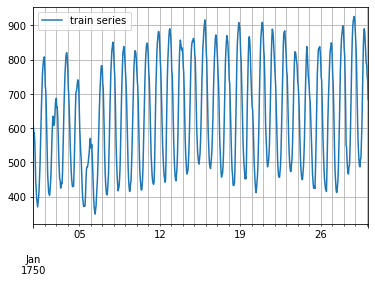

In [59]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
display(train_series)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


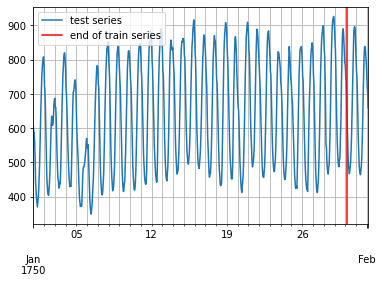

In [4]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [5]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


In [6]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  


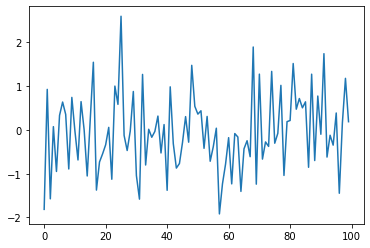

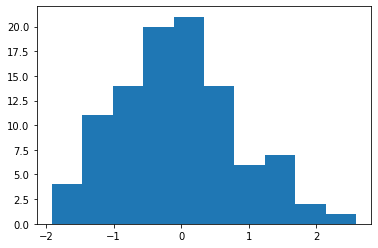

In [73]:
plt.plot(custom_dataset[0])
plt.show()
plt.hist(custom_dataset[0]) 
plt.show()

In [7]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset],
    freq=freq
)

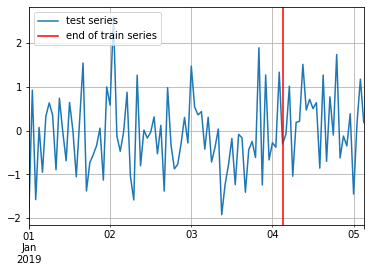

In [77]:
test_series = to_pandas(next(iter(test_ds)))
train_series = to_pandas(next(iter(train_ds)))
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

SimpleFeedForwardEstimator shows how to build a simple MLP (multilayer perceptron) model predicting the next target time-steps given the previous ones.

Given that we want to define a gluon model trainable by SGD, we inherit the parent class GluonEstimator that handles most of the logic for fitting a neural-network.


* freq – Time time granularity of the data
* prediction_length – Length of the prediction horizon
* trainer – Trainer object to be used (default: Trainer())
* num_hidden_dimensions – Number of hidden nodes in each layer (default: [40, 40])
* context_length – Number of time units that condition the predictions (default: None, in which case context_length = prediction_length)      

In [8]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [9]:
predictor = estimator.train(dataset.train)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 100.51it/s, epoch=5/5, avg_epoch_loss=4.77]


In [10]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [11]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [12]:
# first entry of the time series list
ts_entry = tss[0]

In [13]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [14]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [15]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [16]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [17]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


In [18]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [654.94604 605.5991  601.8148  498.45993 481.44397 476.48825 513.16986
 482.1115  497.67868 577.7551  637.479   692.46216 707.18164 839.525
 895.40717 885.4504  860.5923  806.598   751.6473  867.71985 868.95624
 801.6593  741.2283  722.3684  655.6881  551.3756  555.5666  469.44128
 477.93466 368.88068 502.55087 465.11993 501.45673 529.8006  633.0236
 680.47736 700.44525 792.4116  849.6319  879.30054 822.62256 876.9567
 912.30084 878.6749  846.074   888.9102  784.7455  703.608  ]
0.5-quantile (median) of the future window:
 [645.0007  621.7663  599.897   490.90927 474.3094  486.66672 509.1671
 500.1548  494.8744  590.29645 616.43427 691.4809  716.5262  829.5553
 889.0347  888.32874 899.144   820.4066  779.2891  875.1014  875.64795
 794.3249  725.75    715.6505  653.83105 563.1283  571.05597 476.3625
 472.84827 362.153   499.74106 470.98264 508.7735  529.3588  629.5037
 671.9597  705.574   793.7748  824.0849  869.51654 815.05066 874.49054
 900.4462  877.563   

In [19]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

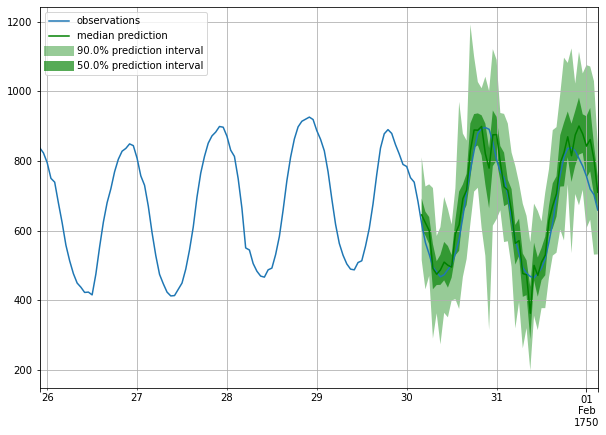

In [20]:
plot_prob_forecasts(ts_entry, forecast_entry)

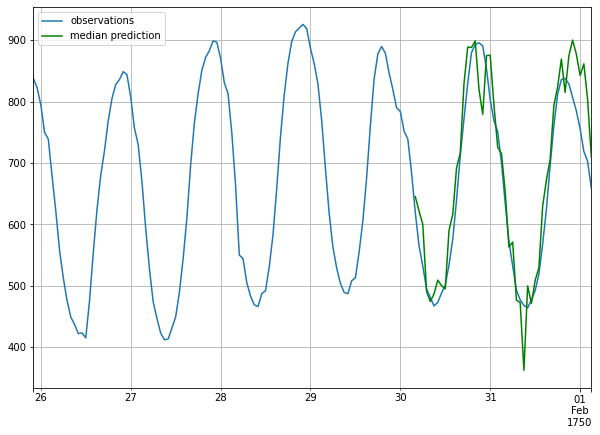

In [82]:
def my_plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    legend = ["observations", "median prediction"]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=[0], color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

my_plot_prob_forecasts(ts_entry, forecast_entry)

In [21]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation:   0%|                                                                      | 0/414 [00:00<?, ?it/s]C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\evaluation\_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 100%|███████████████████████████████████████████████████████████| 414/414 [00:01<00:00, 252.91it/s]


In [22]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 8985734.003205862,
    "abs_error": 9411491.877613068,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 3.747284417270558,
    "MAPE": 0.26879676625780446,
    "sMAPE": 0.1963109809743323,
    "MSIS": 65.52928929841998,
    "QuantileLoss[0.1]": 5449420.8387032505,
    "Coverage[0.1]": 0.10220410628019327,
    "QuantileLoss[0.5]": 9411491.791275024,
    "Coverage[0.5]": 0.5148450080515294,
    "QuantileLoss[0.9]": 7426355.797146701,
    "Coverage[0.9]": 0.8835547504025756,
    "RMSE": 2997.6213909041053,
    "NRMSE": 0.40924153161777105,
    "ND": 0.06465763502730675,
    "wQuantileLoss[0.1]": 0.03743791826853665,
    "wQuantileLoss[0.5]": 0.06465763443415809,
    "wQuantileLoss[0.9]": 0.05101960549495957,
    "mean_absolute_QuantileLoss": 7429089.475708325,
    "mean_wQuantileLoss": 0.05103838606588477,
    "MAE_Coverage": 0.011164787976382382,
    "OWA": NaN
}


In [23]:
item_metrics.head()

item_id            MSE     abs_error  abs_target_sum  abs_target_mean  \
0      0.0    3229.811523   1962.673584         31644.0       659.250000   
1      1.0  154046.145833  17524.412109        124149.0      2586.437500   
2      2.0   32257.632812   6851.509277         65030.0      1354.791667   
3      3.0  315974.291667  20337.363281        235783.0      4912.145833   
4      4.0   88744.583333  10222.220703        131088.0      2731.000000   

   seasonal_error      MASE      MAPE     sMAPE       MSIS  QuantileLoss[0.1]  \
0       42.371302  0.965017  0.061775  0.060452  13.626505        1087.290985   
1      165.107988  2.211231  0.143961  0.132664  14.942773        3906.054370   
2       78.889053  1.809374  0.096046  0.102553  14.245432        3745.661438   
3      258.982249  1.636000  0.084699  0.084619  15.416603       11005.331201   
4      200.494083  1.062191  0.076444  0.072524  13.484286        4945.353369   

   Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.9]  \
0       0.000000        1962.673584       0.750000        1475.113336   
1       0.145833       17524.412598       1.000000        9097.867334   
2       0.000000        6851.509399       0.145833        2105.012305   
3       0.062500       20337.363525       0.458333        8593.963867   
4       0.020833       10222.221313       0.791667        7786.658447   

   Coverage[0.9]  
0       1.000000  
1       1.000000  
2       0.854167  
3       0.979167  
4       1.000000

**MASE**: the mean absolute scaled error is a measure of the accuracy of forecasts. It is the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast.

**MSIS**: Mean Scaled Interval Score. Simillar to MASE, MSIS compares the forecast error to a baseline seasonal_error calculated from naive forecast.

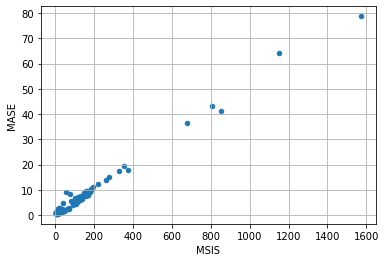

In [24]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# Extended Forecasting Tutorial

## data

In [85]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [86]:
dataset = get_dataset("m4_hourly", regenerate=True)

saving time-series into C:\Users\negstek\.mxnet\gluon-ts\datasets\m4_hourly\train\data.json
saving time-series into C:\Users\negstek\.mxnet\gluon-ts\datasets\m4_hourly\test\data.json


In [90]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
train_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'item_id', 'source'])

In [92]:
# get the first time series in the test set
test_entry = next(iter(dataset.test))
test_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'item_id', 'source'])

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


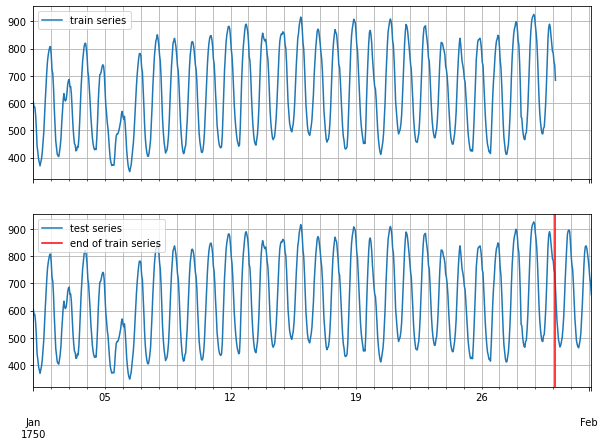

In [93]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [94]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


In [96]:
artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

In [97]:
print(f"prediction length: {artificial_dataset.metadata.prediction_length}")
print(f"frequency: {artificial_dataset.metadata.freq}")

prediction length: 21
frequency: H


In [98]:
print(f"type of train dataset: {type(artificial_dataset.train)}")
print(f"train dataset fields: {artificial_dataset.train[0].keys()}")
print(f"type of test dataset: {type(artificial_dataset.test)}")
print(f"test dataset fields: {artificial_dataset.test[0].keys()}")

type of train dataset: <class 'list'>
train dataset fields: dict_keys(['start', 'target', 'item_id'])
type of test dataset: <class 'list'>
test dataset fields: dict_keys(['start', 'target', 'item_id'])


C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\artificial\_base.py:616: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start=pd.Timestamp(start, freq=self.freq_str),


In [99]:
train_ds = ListDataset(
    artificial_dataset.train,
    freq=artificial_dataset.metadata.freq
)
test_ds = ListDataset(
    artificial_dataset.test,
    freq=artificial_dataset.metadata.freq
)

In [100]:
train_entry = next(iter(train_ds))
train_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq


dict_keys(['start', 'target', 'item_id', 'source'])

In [101]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


In [103]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

Required:
* start: start date of the time series
* target: values of the time series  

Optional:
* feat_static_cat: static (over time) categorical features, list with dimension equal to the number of features
* feat_static_real: static (over time) real features, list with dimension equal to the number of features
* feat_dynamic_cat: dynamic (over time) categorical features, array with shape equal to (number of features, target length)
* feat_dynamic_real: dynamic (over time) real features, array with shape equal to (number of features, target length)  

Added by Transformation:
* time_feat: time related features such as the month or the day
* feat_dynamic_const: expands a constant value feature along the time axis
* feat_dynamic_age: age feature, i.e., a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp
* observed_values: indicator for observed values, i.e., a feature that equals to 1 if the value is observed and 0 if the value is missing
* is_pad: indicator for each time step that shows if it is padded (if the length is not enough)
* forecast_start: forecast start date

In [104]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))
    # pattern - sinusoid with different phase
    sin_minusPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))
    pattern = np.concatenate(
        (
            np.tile(
                sin_minusPi_Pi.reshape(1, -1),
                (int(np.ceil(num_series / 2)),1)
            ),
            np.tile(
                sin_Zero_2Pi.reshape(1, -1),
                (int(np.floor(num_series / 2)), 1)
            )
        ),
        axis=0
    )
    target = noise + pattern
    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate(
        (
            np.zeros((num_series, period)),
            target[:, :-period]
        ),
        axis=1
    )
    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate(
        (
            np.zeros(int(np.ceil(num_series / 2))),
            np.ones(int(np.floor(num_series / 2)))
        ),
        axis=0
    )
    return target, feat_dynamic_real, feat_static_cat

In [105]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 100,
    'num_steps': 24 * 7,
    'prediction_length': 24,
    'freq': '1H',
    'start': [
        pd.Timestamp("01-01-2019", freq='1H')
        for _ in range(100)
    ]
}

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  if __name__ == '__main__':


In [106]:
data_out = create_dataset(
    custom_ds_metadata['num_series'],
    custom_ds_metadata['num_steps'],
    custom_ds_metadata['prediction_length']
)

target, feat_dynamic_real, feat_static_cat = data_out

In [107]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr, fsc) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
            feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

In [108]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr, fsc) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real,
            feat_static_cat)
    ],
    freq=custom_ds_metadata['freq']
)

In [109]:
train_entry = next(iter(train_ds))
train_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

In [110]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\dataset\util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


## Transformations

In [115]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                instance_sampler=ExpectedNumInstanceSampler(
                    num_instances=1,
                    min_future=prediction_length,
                ),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

In [116]:
transformation = create_transformation(
    custom_ds_metadata['freq'],
    2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
    custom_ds_metadata['prediction_length']
)

In [118]:
train_tf = transformation(iter(train_ds), is_train=True)

type(train_tf)

generator

In [119]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [120]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


In [121]:
[k for k in next(iter(train_ds)).keys()]

['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source']

In [122]:
test_tf = transformation(iter(test_ds), is_train=False)

In [123]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [124]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
print(test_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


## Training an existing model

In [125]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

In [126]:
predictor = estimator.train(train_ds)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|███████████████████████████████████████████████| 100/100 [00:01<00:00, 88.97it/s, epoch=5/5, avg_epoch_loss=0.605]


In [129]:
# save the trained model in tmp/
predictor.serialize(Path("/tmp/"))

## Evaluation

In [132]:
# loads it back
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

In [133]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [134]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [135]:
# first entry of the time series list
ts_entry = tss[0]

In [136]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([1.5292157 , 0.85025036, 0.7740374 , 0.941432  , 0.6723822 ],
      dtype=float32)

In [137]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [138]:
# first 5 values
test_ds_entry['target'][:5]

array([1.5292157 , 0.85025036, 0.7740374 , 0.941432  , 0.6723822 ],
      dtype=float32)

In [139]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [140]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2019-01-07 00:00:00
Frequency of the time series: 1H


In [141]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 0.9325081   0.42344588  0.64103895  0.32837272  0.07866158  0.07445934
 -0.14185263  0.1950477   0.0780056   0.4463922   0.62147176  0.93874353
  1.075987    1.2639703   1.6049056   1.9173784   1.8374667   1.8084613
  1.9578193   1.8212906   1.7286431   1.5800556   1.2578841   1.1592294 ]
0.5-quantile (median) of the future window:
 [ 0.9033197   0.5001233   0.672776    0.36360872  0.08165593  0.0909187
 -0.11844075  0.17335606  0.10704582  0.44494534  0.6659758   0.9467166
  1.0972607   1.2285548   1.5955487   1.9096934   1.8352127   1.81152
  1.9721141   1.8075659   1.7403404   1.5337147   1.2483959   1.1800429 ]


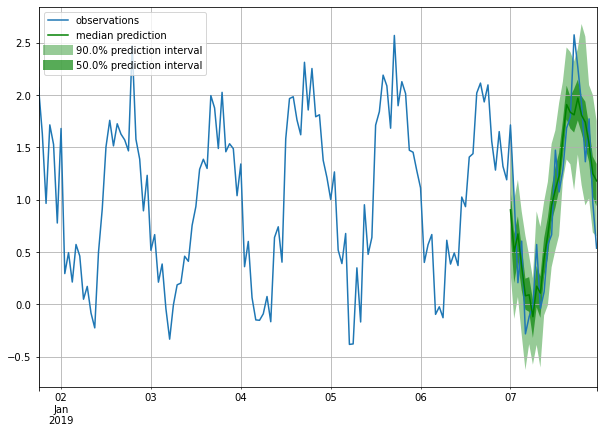

In [143]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    
plot_prob_forecasts(ts_entry, forecast_entry)

In [144]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation:   0%|                                                                      | 0/100 [00:00<?, ?it/s]C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\evaluation\_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 238.10it/s]


In [145]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.11028171872099236,
    "abs_error": 632.8661780357361,
    "abs_target_sum": 2505.765546798706,
    "abs_target_mean": 1.0440689778327943,
    "seasonal_error": 0.3378558193842571,
    "MASE": 0.7880705295996263,
    "MAPE": 2.131493123968442,
    "sMAPE": 0.5338234988848369,
    "MSIS": 5.61631513656073,
    "QuantileLoss[0.1]": 278.89769208133225,
    "Coverage[0.1]": 0.09000000000000002,
    "QuantileLoss[0.5]": 632.8661768203601,
    "Coverage[0.5]": 0.48833333333333334,
    "QuantileLoss[0.9]": 300.9366061121225,
    "Coverage[0.9]": 0.8875,
    "RMSE": 0.33208691440794885,
    "NRMSE": 0.31806989907627725,
    "ND": 0.25256400338182783,
    "wQuantileLoss[0.1]": 0.11130238917908497,
    "wQuantileLoss[0.5]": 0.25256400289679604,
    "wQuantileLoss[0.9]": 0.12009767094794262,
    "mean_absolute_QuantileLoss": 404.2334916712716,
    "mean_wQuantileLoss": 0.16132135434127454,
    "MAE_Coverage": 0.011388888888888902,
    "OWA": NaN
}


In [146]:
item_metrics.head()

item_id       MSE  abs_error  abs_target_sum  abs_target_mean  \
0      NaN  0.143016   7.758640       24.638548         1.026606   
1      NaN  0.107110   5.870077       22.178631         0.924110   
2      NaN  0.160152   7.503420       26.601139         1.108381   
3      NaN  0.111842   6.408135       22.502333         0.937597   
4      NaN  0.058205   4.480352       25.864388         1.077683   

   seasonal_error      MASE      MAPE     sMAPE      MSIS  QuantileLoss[0.1]  \
0        0.351642  0.919336  0.958919  0.656756  5.135023           2.529837   
1        0.340241  0.718862  1.509559  0.550516  4.859851           2.473793   
2        0.323560  0.966259  0.471024  0.619295  7.831570           3.357760   
3        0.311026  0.858467  1.047767  0.614643  6.441520           3.169918   
4        0.313119  0.596199  1.010989  0.391646  6.240301           2.515966   

   Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.9]  \
0       0.083333           7.758640       0.583333           3.507081   
1       0.083333           5.870078       0.666667           2.718594   
2       0.083333           7.503420       0.500000           3.995046   
3       0.166667           6.408135       0.583333           3.326975   
4       0.000000           4.480352       0.500000           2.862366   

   Coverage[0.9]  
0       0.875000  
1       0.916667  
2       0.791667  
3       0.958333  
4       0.875000

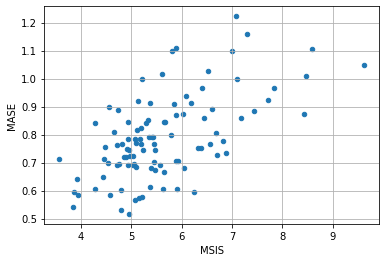

In [147]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

## Create your own model

### Point forecasts with a simple feedforward network

In [155]:
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

class MyTrainNetwork(MyNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)

class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

In [156]:

class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells

    def create_transformation(self):
        return Chain([])

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [158]:
estimator = MyEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    num_cells=40,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

In [159]:
predictor = estimator.train(train_ds)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 196.86it/s, epoch=5/5, avg_epoch_loss=0.292]


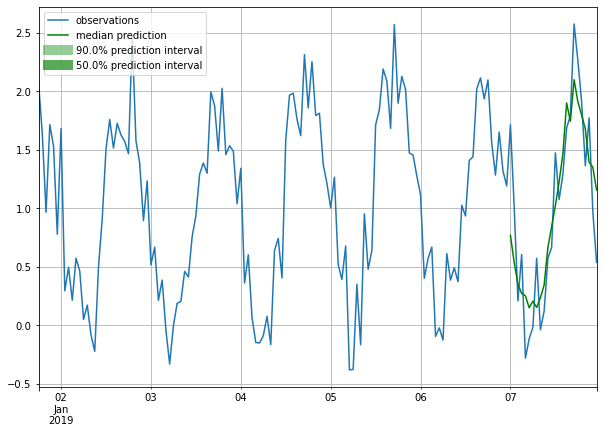

In [161]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_prob_forecasts(tss[0], forecasts[0])

### Probabilistic forecasting¶

In [163]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(
        self,
        prediction_length,
        distr_output,
        num_cells,
        num_sample_paths=100,
        **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))


class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        # compute network output
        net_output = self.nn(past_target)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss


class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        # repeat past target: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # compute network output
        net_output = self.nn(repeated_past_target)

        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()

        # reshape from (batch_size * num_sample_paths, prediction_length) to
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

In [176]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        distr_output: DistributionOutput,
        num_cells: int,
        num_sample_paths: int = 100,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths

    def create_transformation(self):
        return Chain([])

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyProbTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [177]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


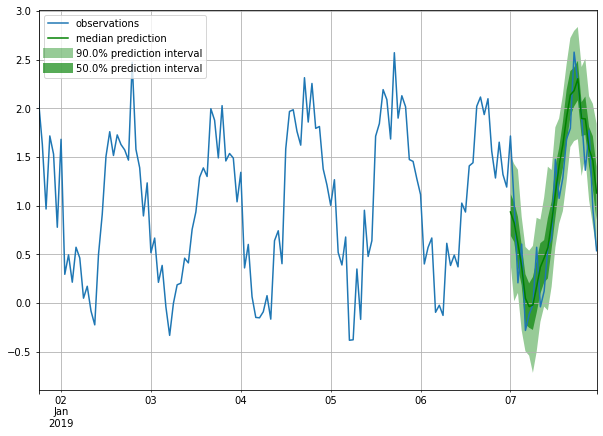

In [178]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_prob_forecasts(tss[0], forecasts[0])

### Add features and scaling

In [168]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(
        self,
        prediction_length,
        context_length,
        distr_output,
        num_cells,
        num_sample_paths=100,
        scaling=True,
        **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()
        self.scaling = scaling

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))

            if scaling:
                self.scaler = MeanScaler(keepdims=True)
            else:
                self.scaler = NOPScaler(keepdims=True)

    def compute_scale(self, past_target, past_observed_values):
        # scale shape is (batch_size, 1)
        _, scale = self.scaler(
            past_target.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
        )

        return scale


class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target, past_observed_values, past_feat_dynamic_real):
        # compute scale
        scale = self.compute_scale(past_target, past_observed_values)

        # scale target and time features
        past_target_scale = F.broadcast_div(past_target, scale)
        past_feat_dynamic_real_scale = F.broadcast_div(past_feat_dynamic_real.squeeze(axis=-1), scale)

        # concatenate target and time features to use them as input to the network
        net_input = F.concat(past_target_scale, past_feat_dynamic_real_scale, dim=-1)

        # compute network output
        net_output = self.nn(net_input)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss


class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target, past_observed_values, past_feat_dynamic_real):
        # repeat fields: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        repeated_past_observed_values = past_observed_values.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        repeated_past_feat_dynamic_real = past_feat_dynamic_real.repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # compute scale
        scale = self.compute_scale(repeated_past_target, repeated_past_observed_values)

        # scale repeated target and time features
        repeated_past_target_scale = F.broadcast_div(repeated_past_target, scale)
        repeated_past_feat_dynamic_real_scale = F.broadcast_div(repeated_past_feat_dynamic_real.squeeze(axis=-1), scale)

        # concatenate target and time features to use them as input to the network
        net_input = F.concat(repeated_past_target_scale, repeated_past_feat_dynamic_real_scale, dim=-1)

        # compute network oputput
        net_output = self.nn(net_input)

        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()

        # reshape from (batch_size * num_sample_paths, prediction_length) to
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

In [169]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        distr_output: DistributionOutput,
        num_cells: int,
        num_sample_paths: int = 100,
        scaling: bool = True,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.scaling = scaling

    def create_transformation(self):
        # Feature transformation that the model uses for input.
        return AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        )

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_DYNAMIC_REAL,
                FieldName.OBSERVED_VALUES,
            ],
        )
        input_names = get_hybrid_forward_input_names(MyProbTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_DYNAMIC_REAL,
                FieldName.OBSERVED_VALUES,
            ],
        )

        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [170]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

In [171]:
predictor = estimator.train(train_ds)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|███████████████████████████████████████████████| 100/100 [00:01<00:00, 91.86it/s, epoch=5/5, avg_epoch_loss=0.421]


In [173]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

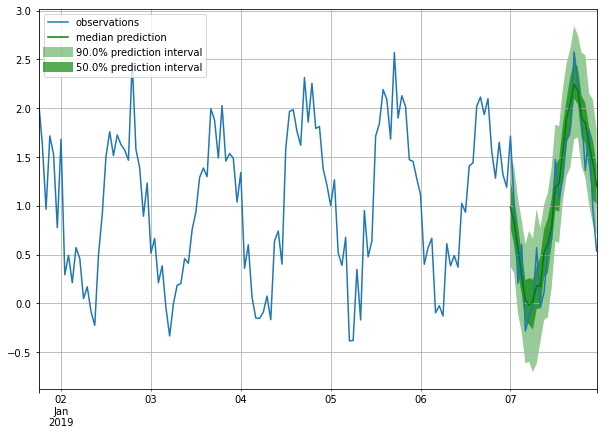

In [174]:
forecasts = list(forecast_it)
tss = list(ts_it)
plot_prob_forecasts(tss[0], forecasts[0])

### From feedforward to RNN

In [179]:
class MyProbRNN(gluon.HybridBlock):
    def __init__(self,
        prediction_length,
        context_length,
        distr_output,
        num_cells,
        num_layers,
        num_sample_paths=100,
        scaling=True,
        **kwargs
     ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_layers = num_layers
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()
        self.scaling = scaling

        with self.name_scope():
            self.rnn = mx.gluon.rnn.HybridSequentialRNNCell()
            for k in range(self.num_layers):
                cell = mx.gluon.rnn.LSTMCell(hidden_size=self.num_cells)
                cell = mx.gluon.rnn.ResidualCell(cell) if k > 0 else cell
                self.rnn.add(cell)

            if scaling:
                self.scaler = MeanScaler(keepdims=True)
            else:
                self.scaler = NOPScaler(keepdims=True)

    def compute_scale(self, past_target, past_observed_values):
        # scale is computed on the context length last units of the past target
        # scale shape is (batch_size, 1, *target_shape)
        _, scale = self.scaler(
            past_target.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
        )

        return scale

    def unroll_encoder(
        self,
        F,
        past_target,
        past_observed_values,
        future_target=None,
        future_observed_values=None
    ):
        # overall target field
        # input target from -(context_length + prediction_length + 1) to -1
        if future_target is not None:  # during training
            target_in = F.concat(
                past_target, future_target, dim=-1
            ).slice_axis(
                axis=1, begin=-(self.context_length + self.prediction_length + 1), end=-1
            )

            # overall observed_values field
            # input observed_values corresponding to target_in
            observed_values_in = F.concat(
                past_observed_values, future_observed_values, dim=-1
            ).slice_axis(
                axis=1, begin=-(self.context_length + self.prediction_length + 1), end=-1
            )

            rnn_length = self.context_length + self.prediction_length
        else:  # during inference
            target_in = past_target.slice_axis(
                axis=1, begin=-(self.context_length + 1), end=-1
            )

            # overall observed_values field
            # input observed_values corresponding to target_in
            observed_values_in = past_observed_values.slice_axis(
                axis=1, begin=-(self.context_length + 1), end=-1
            )

            rnn_length = self.context_length

        # compute scale
        scale = self.compute_scale(target_in, observed_values_in)

        # scale target_in
        target_in_scale = F.broadcast_div(target_in, scale)

        # compute network output
        net_output, states = self.rnn.unroll(
            inputs=target_in_scale,
            length=rnn_length,
            layout="NTC",
            merge_outputs=True,
        )

        return net_output, states, scale


class MyProbTrainRNN(MyProbRNN):
    def hybrid_forward(
        self,
        F,
        past_target,
        future_target,
        past_observed_values,
        future_observed_values
    ):
        net_output, _, scale = self.unroll_encoder(
            F, past_target, past_observed_values, future_target, future_observed_values
        )

        # output target from -(context_length + prediction_length) to end
        target_out = F.concat(
            past_target, future_target, dim=-1
        ).slice_axis(
            axis=1, begin=-(self.context_length + self.prediction_length), end=None
        )

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # negative log-likelihood
        loss = distr.loss(target_out)
        return loss


class MyProbPredRNN(MyProbTrainRNN):
    def sample_decoder(self, F, past_target, states, scale):
        # repeat fields: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_states = [
            s.repeat(repeats=self.num_sample_paths, axis=0)
            for s in states
        ]
        repeated_scale = scale.repeat(repeats=self.num_sample_paths, axis=0)

        # first decoder input is the last value of the past_target, i.e.,
        # the previous value of the first time step we want to forecast
        decoder_input = past_target.slice_axis(
            axis=1, begin=-1, end=None
        ).repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # list with samples at each time step
        future_samples = []

        # for each future time step we draw new samples for this time step and update the state
        # the drawn samples are the inputs to the rnn at the next time step
        for k in range(self.prediction_length):
            rnn_outputs, repeated_states = self.rnn.unroll(
                inputs=decoder_input,
                length=1,
                begin_state=repeated_states,
                layout="NTC",
                merge_outputs=True,
            )

            # project network output to distribution parameters domain
            distr_args = self.proj_distr_args(rnn_outputs)

            # compute distribution
            distr = self.distr_output.distribution(distr_args, scale=repeated_scale)

            # draw samples (batch_size * num_samples, 1)
            new_samples = distr.sample()

            # append the samples of the current time step
            future_samples.append(new_samples)

            # update decoder input for the next time step
            decoder_input = new_samples

        samples = F.concat(*future_samples, dim=1)

        # (batch_size, num_samples, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

    def hybrid_forward(self, F, past_target, past_observed_values):
        # unroll encoder over context_length
        net_output, states, scale = self.unroll_encoder(
            F, past_target, past_observed_values
        )

        samples = self.sample_decoder(F, past_target, states, scale)

        return samples

In [180]:
class MyProbRNNEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        distr_output: DistributionOutput,
        num_cells: int,
        num_layers: int,
        num_sample_paths: int = 100,
        scaling: bool = True,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_layers = num_layers
        self.num_sample_paths = num_sample_paths
        self.scaling = scaling

    def create_transformation(self):
        # Feature transformation that the model uses for input.
        return AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        )

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length,
            ),
            past_length=self.context_length + 1,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_DYNAMIC_REAL,
                FieldName.OBSERVED_VALUES,
            ],
        )
        input_names = get_hybrid_forward_input_names(MyProbTrainRNN)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )

    def create_training_network(self) -> MyProbTrainRNN:
        return MyProbTrainRNN(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_layers=self.num_layers,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length + 1,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_DYNAMIC_REAL,
                FieldName.OBSERVED_VALUES,
            ],
        )
        prediction_network = MyProbPredRNN(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_layers=self.num_layers,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [181]:
estimator = MyProbRNNEstimator(
    prediction_length=24,
    context_length=48,
    freq="1H",
    num_cells=40,
    num_layers=2,
    distr_output=GaussianOutput(),
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

predictor = estimator.train(train_ds)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
C:\Users\negstek\anaconda3\envs\py37\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s, epoch=5/5, avg_epoch_loss=0.274]


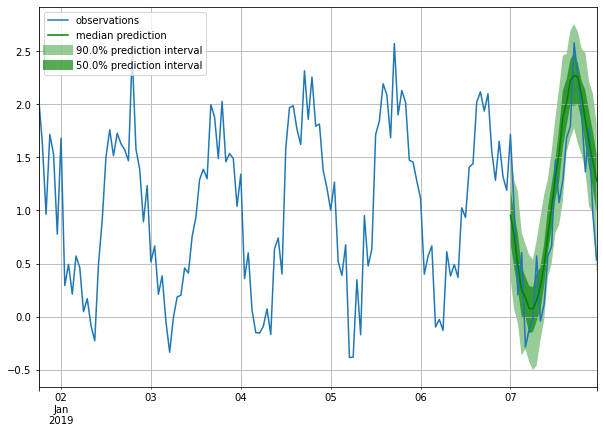

In [182]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_prob_forecasts(tss[0], forecasts[0])